In [1]:
import tensorflow as tf
import math
import numpy as np
import argparse
import os
import sys
import collections
import zipfile
import random
from pathlib import Path
from tensorflow.contrib.tensorboard.plugins import projector
from tempfile import gettempdir
from sklearn import model_selection, linear_model, preprocessing, svm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import make_pipeline
 # pylint: disable=g-import-not-at-top
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
# Give a folder path as an argument with '--log_dir' to save
# TensorBoard summaries. Default is a log folder in current directory.
# current_path = os.path.dirname(os.path.realpath(sys.argv[0]))
current_path = "/Users/Ganymedian/Desktop/dynamic-rw/output/blog-catalog/m1/"
start_id = 1
parser = argparse.ArgumentParser()
parser.add_argument(
    '--log_dir',
    type=str,
    default=os.path.join(current_path, 'log'),
    help='The log directory for TensorBoard summaries.')
FLAGS, unparsed = parser.parse_known_args()

#### Read data

In [3]:
vocab_size = 10400
batch_size = 100
embed_size = 128  # Dimension of the embedding vector.
num_sampled = 10  # Number of negative examples to sample.
l_rate = 0.2

In [4]:
def read_data(fname):
    print(fname)
    rws = np.concatenate([
        np.loadtxt(f.open(), delimiter='\t', dtype=int)
        for f in rw_location.glob(fname)
        if f.stat().st_size > 0
    ])
    return rws

In [5]:
rw_location = Path("/Users/Ganymedian/Desktop/dynamic-rw/output/blog-catalog/m1/")
filename = "gPairs-w4-s8.txt"
# filename = "test.txt"
seed = 1234
np.random.seed(seed=seed)
data = read_data(filename) - start_id
print('Data size', len(data))
# print(data)

gPairs-w4-s8.txt
Data size 7326400


In [6]:
data_index = 0
data_size = len(data)
np.random.seed(seed=seed)
np.random.shuffle(data)
print(data)
batches = np.vsplit(data, data_size/batch_size)
# [print(len(m)) for m in batches]

def generate_batch():
    global data_index
    next_batch = batches[data_index]
    data_index += 1
    targets = next_batch[:,0]
    contexts = next_batch[:,1].reshape(len(next_batch),1)
    return targets, contexts

def end_of_batch():
    if (data_index >= len(batches)):
        return True 
    else:
        return False
    
def reset_batch_gen():
    global data_index
    data_index = 0

[[3086 3086]
 [  65 4025]
 [5428 5767]
 ...
 [7213 7213]
 [9516 9516]
 [6250 6250]]


In [7]:
# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. These 3 variables are used only for
# displaying model accuracy, they don't affect calculation.
valid_size = 2  # Random set of words to evaluate similarity on.
valid_window = 10  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

In [8]:
graph = tf.Graph()

with graph.as_default():

  # Input data.
  with tf.name_scope('inputs'):
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_contexts = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  # Ops and variables pinned to the CPU because of missing GPU implementation
  with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
    with tf.name_scope('embeddings'):
        embeddings = tf.Variable(
              tf.random_uniform([vocab_size, embed_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    with tf.name_scope('weights'):
          nce_weights = tf.Variable(
              tf.truncated_normal(
                  [vocab_size, embed_size],
                  stddev=1.0 / math.sqrt(embed_size)))
    with tf.name_scope('biases'):
          nce_biases = tf.Variable(tf.zeros([vocab_size]))
  # Compute the average NCE loss for the batch.
  # tf.nce_loss automatically draws a new sample of the negative labels each
  # time we evaluate the loss.
  # Explanation of the meaning of NCE loss:
  #   http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(
            tf.nn.nce_loss(
                weights=nce_weights,
                biases=nce_biases,
                labels=train_contexts,
                inputs=embed,
                num_sampled=num_sampled,
                num_classes=vocab_size))
    # Add the loss value as a scalar to summary.
    tf.summary.scalar('loss', loss)
    # Construct the SGD optimizer using a learning rate of 1.0.
    with tf.name_scope('optimizer'):
        optimizer = tf.train.GradientDescentOptimizer(l_rate).minimize(loss)
    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,
                                            valid_dataset)
    similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

    # Merge all summaries.
    merged = tf.summary.merge_all()

    # Add variable initializer.
    init = tf.global_variables_initializer()

    # Create a saver.
    saver = tf.train.Saver()

### Begin Training

In [9]:
num_steps = len(batches)
reset_batch_gen()
with tf.Session(graph=graph) as session:
    # Open a writer to write summaries.
    writer = tf.summary.FileWriter(FLAGS.log_dir, session.graph)

    # We must initialize all variables before we use them.
    init.run()
    print('Initialized')

    average_loss = 0
    for step in range(num_steps):
#         print(step)
        inputs, contexts = generate_batch()
        feed_dict = {train_inputs: inputs, train_contexts: contexts}

        # Define metadata variable.
        run_metadata = tf.RunMetadata()

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        # Also, evaluate the merged op to get all summaries from the returned "summary" variable.
        # Feed metadata variable to session for visualizing the graph in TensorBoard.
        _, summary, loss_val = session.run(
            [optimizer, merged, loss],
            feed_dict=feed_dict,
            run_metadata=run_metadata)
        average_loss += loss_val

        # Add returned summaries to writer in each step.
        writer.add_summary(summary, step)
        # Add metadata to visualize the graph for the last run.
        if step == (num_steps - 1):
          writer.add_run_metadata(run_metadata, 'step%d' % step)

        if step % 50 == 0:
          if step > 0:
            average_loss /= 50
          # The average loss is an estimate of the loss over the last 2000 batches.
          print('Average loss at step ', step, ': ', average_loss)
          average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
          sim = similarity.eval()
          for i in range(valid_size):
            valid_word = valid_examples[i]
            top_k = 8  # number of nearest neighbors
            nearest = (-sim[i, :]).argsort()[1:top_k + 1]
            log_str = 'Nearest to %s:' % valid_word
            for k in range(top_k):
              close_word = nearest[k]
              log_str = '%s %s,' % (log_str, close_word)
            print(log_str)

    final_embeddings = normalized_embeddings.eval()
    # Write corresponding labels for the embeddings.

    with open(FLAGS.log_dir + '/metadata.tsv', 'w') as f:
        for i in range(vocab_size):
          f.write(str(i+start_id) + '\n')

    # Save the model for checkpoints.
    saver.save(session, os.path.join(FLAGS.log_dir, 'model.ckpt'))

    # Create a configuration for visualizing embeddings with the labels in TensorBoard.
    config = projector.ProjectorConfig()
    embedding_conf = config.embeddings.add()
    embedding_conf.tensor_name = embeddings.name
    embedding_conf.metadata_path = os.path.join(FLAGS.log_dir, 'metadata.tsv')
    projector.visualize_embeddings(writer, config)

    writer.close()

Initialized
Average loss at step  0 :  63.08530807495117
Nearest to 2: 7903, 69, 2696, 795, 4127, 1726, 6965, 31,
Nearest to 9: 3663, 2677, 7075, 2510, 4442, 4723, 3310, 8678,
Average loss at step  50 :  48.314411315917965
Average loss at step  100 :  45.79821376800537
Average loss at step  150 :  41.96919704437256
Average loss at step  200 :  43.060015182495114
Average loss at step  250 :  38.82096683502197
Average loss at step  300 :  41.89749347686767
Average loss at step  350 :  40.47307857513428
Average loss at step  400 :  39.24345432281494
Average loss at step  450 :  40.01040958404541
Average loss at step  500 :  38.97160919189453
Average loss at step  550 :  39.45461391448975
Average loss at step  600 :  38.2632075881958
Average loss at step  650 :  38.364429016113284
Average loss at step  700 :  34.37534116744995
Average loss at step  750 :  36.2626382446289
Average loss at step  800 :  34.55638921737671
Average loss at step  850 :  36.31722541809082
Average loss at step  900

Average loss at step  8350 :  15.01264132618904
Average loss at step  8400 :  11.382423333525658
Average loss at step  8450 :  15.843119797706605
Average loss at step  8500 :  13.790881195068359
Average loss at step  8550 :  13.214310402870177
Average loss at step  8600 :  14.809744005203248
Average loss at step  8650 :  12.636033027172088
Average loss at step  8700 :  15.619089860916137
Average loss at step  8750 :  13.426828072071075
Average loss at step  8800 :  12.927043834924698
Average loss at step  8850 :  13.510139672756194
Average loss at step  8900 :  13.696301810741424
Average loss at step  8950 :  14.72129076719284
Average loss at step  9000 :  12.750261919498444
Average loss at step  9050 :  11.732833297252656
Average loss at step  9100 :  13.060602287650108
Average loss at step  9150 :  12.036226231455803
Average loss at step  9200 :  11.760471987724305
Average loss at step  9250 :  13.285990761220456
Average loss at step  9300 :  12.263235522508621
Average loss at step  

Average loss at step  16750 :  4.464276714622974
Average loss at step  16800 :  3.5867829382419587
Average loss at step  16850 :  3.0239744439721106
Average loss at step  16900 :  5.434337801337242
Average loss at step  16950 :  5.01233450114727
Average loss at step  17000 :  4.561363677382469
Average loss at step  17050 :  5.863080714941025
Average loss at step  17100 :  5.225208818912506
Average loss at step  17150 :  4.369750583171845
Average loss at step  17200 :  3.773611161112785
Average loss at step  17250 :  4.718094415664673
Average loss at step  17300 :  4.630157750844956
Average loss at step  17350 :  5.432171794772148
Average loss at step  17400 :  4.003055675029755
Average loss at step  17450 :  3.1952126109600067
Average loss at step  17500 :  3.190406289100647
Average loss at step  17550 :  4.173774354457855
Average loss at step  17600 :  4.3415191894769665
Average loss at step  17650 :  4.5765102082490925
Average loss at step  17700 :  4.0076550242304805
Average loss at

Average loss at step  25150 :  1.8246972700953483
Average loss at step  25200 :  1.9799916929006576
Average loss at step  25250 :  1.263619665503502
Average loss at step  25300 :  1.919578619003296
Average loss at step  25350 :  1.9247379148006438
Average loss at step  25400 :  1.502674359679222
Average loss at step  25450 :  2.116018385589123
Average loss at step  25500 :  1.269088074862957
Average loss at step  25550 :  2.8276822420954706
Average loss at step  25600 :  2.078286197781563
Average loss at step  25650 :  2.044270456433296
Average loss at step  25700 :  1.8202953836321831
Average loss at step  25750 :  1.882304358780384
Average loss at step  25800 :  1.7346816742420197
Average loss at step  25850 :  1.9458190935850144
Average loss at step  25900 :  1.4695910894870758
Average loss at step  25950 :  2.0861775487661363
Average loss at step  26000 :  2.583795090317726
Average loss at step  26050 :  0.9855936422944069
Average loss at step  26100 :  1.9169980916380882
Average l

Average loss at step  33300 :  0.8602476555109024
Average loss at step  33350 :  1.1544659945368767
Average loss at step  33400 :  0.7189134985208512
Average loss at step  33450 :  0.7861710864305497
Average loss at step  33500 :  0.4567035087943077
Average loss at step  33550 :  1.3409055218100547
Average loss at step  33600 :  0.6656280435621739
Average loss at step  33650 :  0.622572869360447
Average loss at step  33700 :  1.1125514990091323
Average loss at step  33750 :  0.8135216936469079
Average loss at step  33800 :  0.965311570763588
Average loss at step  33850 :  0.5324739542603493
Average loss at step  33900 :  0.9431503358483314
Average loss at step  33950 :  1.0781766164302826
Average loss at step  34000 :  1.137687792479992
Average loss at step  34050 :  0.7395326448976993
Average loss at step  34100 :  0.8143764840066433
Average loss at step  34150 :  1.388533134162426
Average loss at step  34200 :  0.6112580372393132
Average loss at step  34250 :  0.7569889733195305
Aver

Average loss at step  41400 :  0.46856444656848906
Average loss at step  41450 :  0.4989230717718601
Average loss at step  41500 :  0.5051733760535717
Average loss at step  41550 :  0.5066236099600792
Average loss at step  41600 :  0.5999824091792106
Average loss at step  41650 :  0.3798510381579399
Average loss at step  41700 :  0.6037141571938992
Average loss at step  41750 :  0.4321805380284786
Average loss at step  41800 :  0.5381005866825581
Average loss at step  41850 :  0.4866219379007816
Average loss at step  41900 :  0.523280523121357
Average loss at step  41950 :  0.4229298160970211
Average loss at step  42000 :  0.4153603364527225
Average loss at step  42050 :  0.3772012674808502
Average loss at step  42100 :  0.41178472846746444
Average loss at step  42150 :  0.3927138581871986
Average loss at step  42200 :  0.38846427232027053
Average loss at step  42250 :  0.6088311514258384
Average loss at step  42300 :  0.5240759889781476
Average loss at step  42350 :  0.385530140399932

Average loss at step  49600 :  0.3216203212738037
Average loss at step  49650 :  0.4039351487159729
Average loss at step  49700 :  0.22380666732788085
Average loss at step  49750 :  0.4499937263131142
Average loss at step  49800 :  0.4317432673275471
Average loss at step  49850 :  0.3141426561772823
Average loss at step  49900 :  0.3373208041489124
Average loss at step  49950 :  0.30662885785102845
Average loss at step  50000 :  0.3126246640086174
Nearest to 2: 1205, 7903, 3819, 10244, 3763, 6182, 766, 2061,
Nearest to 9: 7075, 9497, 6065, 2677, 6279, 2976, 1345, 9060,
Average loss at step  50050 :  0.24156928837299346
Average loss at step  50100 :  0.3334947000443935
Average loss at step  50150 :  0.380252515822649
Average loss at step  50200 :  0.39340526446700097
Average loss at step  50250 :  0.3056362071633339
Average loss at step  50300 :  0.2595731093734503
Average loss at step  50350 :  0.48915335059165954
Average loss at step  50400 :  0.34403065644204617
Average loss at step 

Average loss at step  57650 :  0.2953867910802364
Average loss at step  57700 :  0.23594455435872078
Average loss at step  57750 :  0.338273511081934
Average loss at step  57800 :  0.317104811668396
Average loss at step  57850 :  0.2770362521708012
Average loss at step  57900 :  0.2784011016786099
Average loss at step  57950 :  0.2968102511763573
Average loss at step  58000 :  0.2340497800707817
Average loss at step  58050 :  0.25497250467538835
Average loss at step  58100 :  0.20436914324760436
Average loss at step  58150 :  0.21278134629130363
Average loss at step  58200 :  0.221567442715168
Average loss at step  58250 :  0.234193157851696
Average loss at step  58300 :  0.20011682987213134
Average loss at step  58350 :  0.27555200934410096
Average loss at step  58400 :  0.2642353459447622
Average loss at step  58450 :  0.39803224816918376
Average loss at step  58500 :  0.20459269493818283
Average loss at step  58550 :  0.26913427144289015
Average loss at step  58600 :  0.248860739991

Average loss at step  65700 :  0.22782692670822144
Average loss at step  65750 :  0.19273047015070915
Average loss at step  65800 :  0.225618404597044
Average loss at step  65850 :  0.2339963100105524
Average loss at step  65900 :  0.24669372603297235
Average loss at step  65950 :  0.16412678614258766
Average loss at step  66000 :  0.24801309309899808
Average loss at step  66050 :  0.28042781427502633
Average loss at step  66100 :  0.1986023509502411
Average loss at step  66150 :  0.22672744564712047
Average loss at step  66200 :  0.3175330502539873
Average loss at step  66250 :  0.49226571261882784
Average loss at step  66300 :  0.3225605984032154
Average loss at step  66350 :  0.31824095636606214
Average loss at step  66400 :  0.26531179875135424
Average loss at step  66450 :  0.22624082818627358
Average loss at step  66500 :  0.2574849942326546
Average loss at step  66550 :  0.25049013309180734
Average loss at step  66600 :  0.24675057597458364
Average loss at step  66650 :  0.18377

### Step 6: Visualize the embeddings.

34
10400
10046->3
10053->2
10054->23
10058->19
10063->15
10069->3
10084->24
10098->5
10100->25
10109->32
10115->3
10140->7
10142->19
10143->1
10146->10
10158->22
10164->3
10167->11
10182->3
10215->6
10219->36
10225->20
10230->8
10245->8
10257->19
10258->24
10260->6
10261->3
10269->18
10272->25
10291->2
10297->6
10298->24
10303->5


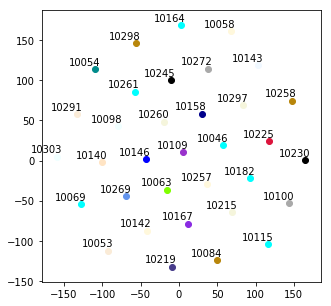

In [15]:
# pylint: disable=missing-docstring
# Function to draw visualization of distance between embeddings.
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 5
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

tsne_seed = 123

def plot_with_labels(low_dim_embs, labels, filename):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    #   plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y, color=node_colors[(node_labels[label-1]-1)])
        print(str(label) + '->' + str(node_labels[label-1]))
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom')

    plt.savefig(filename)

try:
#     print(final_embeddings)
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact', random_state=tsne_seed)
    plot_only = 34
    nodes_to_plot = curr_vocab[len(curr_vocab)-plot_only:len(curr_vocab)]
#     low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    print(len(final_embeddings[nodes_to_plot-1]))
    print(len(final_embeddings))
    low_dim_embs = tsne.fit_transform(final_embeddings[nodes_to_plot-1])
#     labels = [(i+start_id) for i in range(plot_only)]
    labels = nodes_to_plot
    plot_with_labels(low_dim_embs, labels, os.path.join(gettempdir(), 'tsne.png'))

except ImportError as ex:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')
    print(ex)

In [14]:
def read_labels(fname):
    rws = np.concatenate([
        np.loadtxt(f.open(), delimiter='\t', usecols=(0, 1), dtype=int) # accepts only the first label
        for f in l_location.glob(fname)
        if f.stat().st_size > 0
    ])

    print(rws)
    return (rws[:,0],rws[:,1])

def read_vocabs(fname):
    rws = np.concatenate([
        np.loadtxt(f.open(), dtype=int) # accepts only the first label
        for f in l_location.glob(fname)
        if f.stat().st_size > 0
    ])

    print(rws)
    return rws

l_location = Path("/Users/Ganymedian/Desktop/dynamic-rw/output/blog-catalog/")
lf_name = "sorted-labels.txt"
vocab_file = "gPairs-vocabs-w4-s8.txt"
v_labels = read_labels(lf_name)
curr_vocab = read_vocabs(vocab_file)
nodes = v_labels[0]
print(len(curr_vocab))
node_labels = v_labels[1]
# node_labels = node_labels[curr_vocab-1]
node_colors = []

import matplotlib
for name, hex in matplotlib.colors.cnames.items():
    node_colors.append(name)

[[    1    21]
 [    2     8]
 [    3     6]
 ...
 [10310    29]
 [10311    22]
 [10312    16]]
[    1     3     9 ... 10297 10298 10303]
1928


In [ ]:
from random import randint
colors = []



In [ ]:
r_seed= 123
def class_train_test(vectors, train_size, test_size):
# Split using sklearn ShuffleSplit
    ss = model_selection.ShuffleSplit(n_splits=1,
                                      train_size=train_size,
                                      test_size=test_size,
                                        random_state = r_seed)
    train_index, test_index = next(ss.split(vectors))

    train_data = vectors[train_index]
    test_data = vectors[test_index]
    train_labels = node_labels[train_index]
    test_labels  = node_labels[test_index]
    # print(train_labels)
    # print(test_labels)

    # Classifier choice
    #classifier = linear_model.LogisticRegression(C=10)
    classifier = svm.SVC(C=1)

    clf = make_pipeline(preprocessing.StandardScaler(), classifier)
    clf.fit(train_data, train_labels)

    train_pred = clf.predict(train_data)
    test_pred = clf.predict(test_data)
    # print(train_pred)
    # print(test_pred)
    train_acc = clf.score(train_data, train_labels)
    test_acc = clf.score(test_data, test_labels)
    train_f1 = f1_score(train_labels, train_pred, average='micro')
    test_f1 = f1_score(test_labels, test_pred, average='micro')
#     print("Train acc:", train_acc)
#     print("Test acc:", test_acc)
#     print("Train f1:", train_f1)
#     print("Test f1:", test_f1)
    return {'train_acc':train_acc, 'test_acc':test_acc, 'train_f1':train_f1, 'test_f1':test_f1}

In [ ]:
train_size = 0.3
test_size = 1-train_size
lrs = class_train_test(final_embeddings, train_size, test_size)
print(lrs.get('test_f1'))
print(lrs.get('train_f1'))